(dl/03-cnn)=
# Convolutional Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/03-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:** [[CS231n]](https://cs231n.github.io/convolutional-networks/) [[NLP4u]](https://lena-voita.github.io/nlp_course/models/convolutional.html) {cite}`raschka2022` [[Keras Guides]](https://keras.io/guides/transfer_learning/#finetuning)

## Introduction

Deep learning incorporates prior knowledge of the structure input data into the network architecture. In this notebook, we introduce the **convolution layer** $\mathscr{C}_{\boldsymbol{\mathsf{w}}}$ with weights $\boldsymbol{\mathsf{w}}$ for detecting local features. Convolution is a linear operation 
which makes sense for data with localized features, such as images, that exhibit **translation equivariance**, i.e. $\mathscr{C}_{\boldsymbol{\mathsf{w}}} \circ \mathscr{T} = \mathscr{T} \circ \mathscr{C}_{\boldsymbol{\mathsf{w}}}$ where $\mathscr{T}$ is a translation of the input. Note that the weight tensor $\boldsymbol{\mathsf{w}}$ is small since the same operation is applied to multiple parts of the input. Stacking convolutional layers allow the network to learn hierarchical patterns that generalizes to test data. We will apply this architecture to text and image classification.

<br>

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F

DATASET_DIR = Path("./data/").resolve()
DATASET_DIR.mkdir(exist_ok=True)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(torch.__version__)
print(torch.backends.mps.is_built())
print(DEVICE)

2.2.2
True
mps


## Convolution operation

Consider classifying images using a linear model. Flattening the image into a vector 
and feeding it into a fully-connected network is not the best approach.
The large flattened input vector requires a very large weight matrix.
Moreover, it does not consider local spatial correlation of image pixels ({numref}`cat-conv`)
(e.g. applying a fixed permutation to input data results in an equivalent network).
This motivates only mixing nearby pixels in a linear combination resulting in a very sparse banded weight matrix ({numref}`toeplitz`).

```{figure} ../../img/cat.png
---
width: 400px
name: cat-conv
---
Nearby pixels combine to form meaningful features of an image. [Source](https://www.nationalgeographic.com/animals/mammals/facts/domestic-cat)
```

Let $\boldsymbol{\mathsf X}$ be an $n \times n$ input image and $\boldsymbol{\mathsf{S}}$ be the $m \times m$ output feature map. The banded weight matrix reduces the nonzero entries of the weight matrix from $m^2 n^2$ to $m^2{k}^2$ where a local region of $k \times k$ pixels in the input image are mixed. If the feature detector is translationally invariant across the image,
then the weights in each band are **shared**. This further reduces the number of weights to $k^2$!
The resulting linear operation is called a **convolution** in two spatial dimensions:


```{math}
:label: 2dconv
\boldsymbol{\mathsf{S}}_{ij} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
```


Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somewhat preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want spatial information and orientation across a stack of convolution operations to be preserved in the final output.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
name: toeplitz
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values. Note that there can be multiple bands for a 2D kernel. See this [SO answer](https://stackoverflow.com/a/44039201/1091950).
```

```{figure} ../../img/nn/no_padding_no_strides.gif
---
---
The following shows a convolution operation with 3 × 3 kernel for 2D input. This essentially visualizes {eq}`2dconv`. Source: https://github.com/vdumoulin/conv_arithmetic
```


### Convolution layer

Digital images have [multiple channels](https://en.wikipedia.org/wiki/Channel_(digital_image)). The **convolution layer** extends the convolution operation to handle feature maps with multiple **channels**. The output feature map similarly has channels adding a further semantic dimension to the downstream representation. For an RGB image, a convolution layer learns three 2-dimensional kernels $\boldsymbol{\mathsf{K}}_{lc}$ for each output channel, each of which can be thought of as a **feature extractor**. Features across input channels are blended by the kernel:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{lij}
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[c,\,:,\, :]} \circledast {\boldsymbol{\mathsf K}}_{[l,\,{c},\, :,\,:]})_{ij} \\
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1}\sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{c,\, i + x,\, j + y} \, {\boldsymbol{\mathsf K}}_{lcxy} \\
\end{aligned}
$$

for $l = 0, \ldots, {c}_\text{out}-1$. The input and output tensors $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$ have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({c}_\text{out}, {c}_\text{in}, {k}, {k}).$ The resulting feature maps inherit the spatial ordering in its inputs along the spatial dimensions. The entire operation is linear and each convolution operation is independent for each output channel. This particular form is called two-dimensional convolution since it processes inputs with two spatial dimensions. Meanwhile, one-dimensional convolutions can be used to process signals or sequential data. In principle, we can add as many spatial dimensions as required.

In [2]:
!wget -O ./data/shorty.png "https://raw.githubusercontent.com/particle1331/ok-transformer/dev/docs/img/shorty.png"

--2024-07-28 21:11:06--  https://raw.githubusercontent.com/particle1331/ok-transformer/dev/docs/img/shorty.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 902795 (882K) [image/png]
Saving to: ‘./data/shorty.png’

./data/shorty.png   100%[===================>] 881.64K   169KB/s    in 5.2s    

2024-07-28 21:11:12 (171 KB/s) - ‘./data/shorty.png’ saved [902795/902795]



Reproducing the convolution operation over input and output channels:

In [3]:
from torchvision.io import read_image
import torchvision.transforms.functional as fn

def convolve(X, K):
    """Perform 2D convolution over input."""
    h, w = K.shape
    H0, W0 = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1

    S = np.zeros(shape=(H1, W1))
    for i in range(H1):
        for j in range(W1):
            S[i, j] = (X[i:i+h, j:j+w] * K).sum()
    
    return torch.tensor(S)

Decomposing the feature maps:

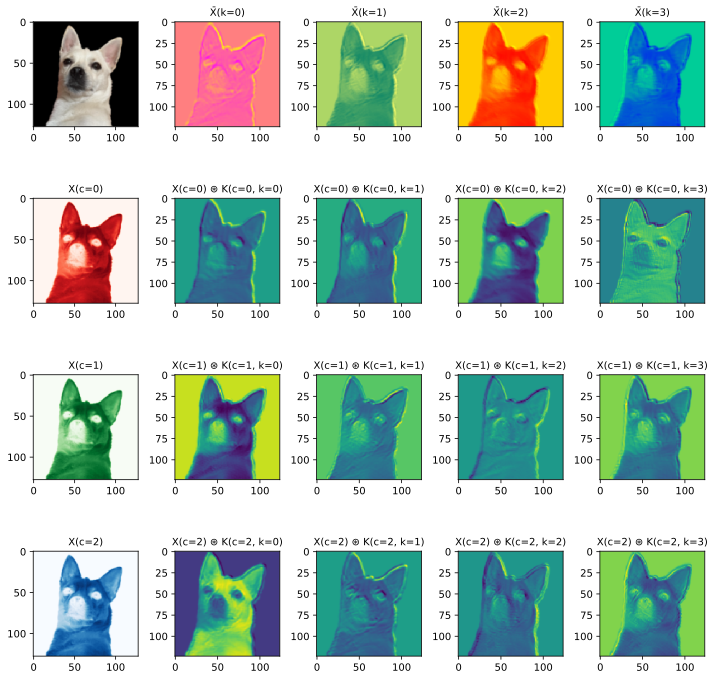

In [4]:
@torch.no_grad()
def conv_components(X, K, u):
    cmaps = ["Reds", "Greens", "Blues"]
    cmaps_out = ["spring", "summer", "autumn", "winter"]
    c_in  = X.shape[1]
    c_out = K.shape[0]
    
    fig, ax = plt.subplots(c_in + 1, c_out + 1, figsize=(10, 10))

    # Input image
    ax[0, 0].imshow(X[0].permute(1, 2, 0))
    for c in range(c_in):
        ax[c+1, 0].set_title(f"X(c={c})", size=10)
        ax[c+1, 0].imshow(X[0, c, :, :], cmap=cmaps[c])

    # Iterate over kernel filters
    out_components = {}
    for k in range(c_out):
        for c in range(c_in):
            out_components[(c, k)] = convolve(X[0, c, :, :], K[k, c, :, :])
            ax[c+1, k+1].imshow(out_components[(c, k)].numpy()) 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})", size=10)

    # Sum convolutions over input channels, then add bias
    out_maps = []
    for k in range(c_out):
        out_maps.append(sum([out_components[(c, k)] for c in range(c_in)]) + u[k])
        ax[0, k+1].imshow(out_maps[k].numpy(), cmaps_out[k])
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f"(k={k})", size=10)

    fig.tight_layout()
    return out_maps


cat = DATASET_DIR / "shorty.png"
X = read_image(str(cat)).unsqueeze(0)[:, :3, :, :]
X = fn.resize(X, size=(128, 128)) / 255.
conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
K, u = conv.weight, conv.bias
components = conv_components(X, K, u);

**Figure.** Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms over `c` form the output map `X̅(k=j)` above. 
This looks like computation in a fully-connected layer, but with convolutions between matrices instead of products between scalars. Hence, convolutional networks perform combinatorial mixing of hierarchical spatial features with depth.

Checking if the output of `conv_components` is consistent with `Conv2d` in PyTorch:

In [5]:
S = torch.stack(components).unsqueeze(0)
P = conv(X)
cmaps_out = ["spring", "summer", "autumn", "winter"]

print("Input shape: ", X.shape)   # (B, c0, H0, W0)
print("Output shape:", S.shape)   # (B, c1, H1, W1)
print("Kernel shape:", K.shape)   # (c1, c0, h, w)
print("Bias shape:  ", u.shape)   # (c1,)
print()
print("MAE (w/ pytorch) =", (S - P).abs().mean().item())

Input shape:  torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 4, 124, 124])
Kernel shape: torch.Size([4, 3, 5, 5])
Bias shape:   torch.Size([4])

MAE (w/ pytorch) = 2.424037095549667e-08


### Padding and stride

**Stride.** The step size of the kernel can be controlled using the stride parameter. A large stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. Note that stride significantly reduces computation by constant factor. Furthermore, strided convolutions have been used as an alternative way to downsample an image {cite}`allconv` (where it is shown to work better or just as well as the usual conv + pool networks). Observe that the spatial size decreases with stride:

In [6]:
conv = lambda s: nn.Conv2d(3, 1, stride=s, kernel_size=3)

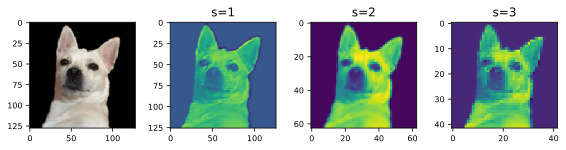

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].imshow(X[0].permute(1, 2, 0))
ax[1].imshow(conv(1)(X)[0, 0].detach().numpy()); ax[1].set_title("s=1")
ax[2].imshow(conv(2)(X)[0, 0].detach().numpy()); ax[2].set_title("s=2")
ax[3].imshow(conv(3)(X)[0, 0].detach().numpy()); ax[3].set_title("s=3")
for i in range(4):
    ax[i].tick_params(axis="both", which="major", labelsize=8)
    
fig.tight_layout();

<br>

**Padding.** Edge pixels of an input image are underrepresented since the kernel has to be kept within the input image. Moreover, information in the edges become lost as we stack more convolutional layers. The simplest to implement is **zero padding** the boundaries (more involved variants exist). Observe the weird effect on the boundaries:

In [8]:
pad  = nn.ZeroPad2d(padding=3)
conv = nn.Conv2d(3, 1, kernel_size=3)

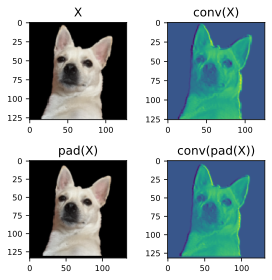

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
vmin = min(conv(X).min(), conv(pad(X)).min())
vmax = max(conv(X).max(), conv(pad(X)).max())
ax[1, 0].imshow(pad(X)[0].permute(1, 2, 0).detach(), vmin=vmin, vmax=vmax); ax[1, 0].set_title("pad(X)")
ax[1, 1].imshow(conv(pad(X))[0, 0].detach(),         vmin=vmin, vmax=vmax); ax[1, 1].set_title("conv(pad(X))")
ax[0, 0].imshow(X[0].permute(1, 2, 0).detach(),      vmin=vmin, vmax=vmax); ax[0, 0].set_title("X")
ax[0, 1].imshow(conv(X)[0, 0].detach(),              vmin=vmin, vmax=vmax); ax[0, 1].set_title("conv(X)")
ax[0, 0].tick_params(axis="both", which="major", labelsize=8)
ax[0, 1].tick_params(axis="both", which="major", labelsize=8)
ax[1, 0].tick_params(axis="both", which="major", labelsize=8)
ax[1, 1].tick_params(axis="both", which="major", labelsize=8)
fig.tight_layout();

<br>

**Remark.** Padding and stride determines the shape of the output. An input of width `w` and symmetric padding `p`, and kernel size `k` with stride `s` has an output width of `⌊(w + 2p - k)/s + 1⌋`. In particular, we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image and no input pixel is dropped.

For `s = 1`, the kernel size should be odd so that it covers the entire input in a symmetric manner. A common choice is `p = (k - 1)/2` which results in same sized outputs (**same convolution**). For `s > 1`, best practice is to choose a kernel size and the smallest `p` such that `s` divides `w + 2p - k` so that the entire input image is symmetrically covered by the kernel.

## Pooling layers

The **receptive field** of a unit is the union of all units that influence its value during forward pass ({numref}`receptive_field`). In particular, units corresponding to each class label should ideally have a receptive field that includes the entire (or at least almost all) input pixels. Otherwise the network will have blind spots in its input. A way to exponentially increase receptive field, and also make the network more robust to noise, is by **downsampling**. Here we do it along the spatial dimensions.

<br>

```{margin}
Fig 14.2 in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
name: receptive_field
width: 28em
---
Receptive field of a pixel in a convolutional network. For an output pixel in an intermediate layer, whose are inputs are formed from stacked convolutions, its larger receptive field indicates that it processes hierarchical features of the original image.
```

**Pooling layers**. Pooling layers downsample an input by performing nonparametric operations that slide across the input like convolutional layers. This can be interpreted as decreasing the resolution of feature maps (sort of zooming out) that deeper layers will work on. Pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```
```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

**Max pooling**. Max pooling layers make the network insensitive to noise or fine-grained details in the input at the cost of some information loss. It can be interpreted as a form of competition between neurons since the gradient only flows through the activated neuron. A soft alternative is **average pooling**. Commonly used parameters are `k=2, s=2` where the pooling regions do not overlap, and `k=3, s=2` where some overlap is allowed.

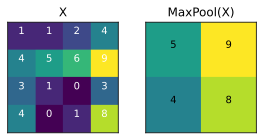

In [10]:
x = torch.tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, None, :, :].float()

pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].set_title("X")
ax[0].imshow(x.numpy()[0, 0, :, :], cmap="viridis", vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, int(x[0, 0, i, j].numpy()), ha="center", va="bottom", color="white")

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(x)[0].detach().permute(1, 2, 0), cmap="viridis", vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, int(pool(x)[0, 0, i, j].numpy()), ha="center", va="bottom", color="black")

fig.tight_layout()

Using a large kernel relative to the input can result in information loss:

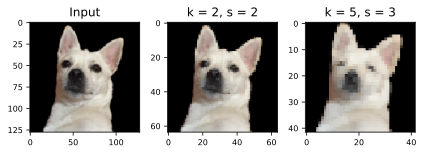

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3))
ax[0].imshow(X[0, :, :, :].permute(1, 2, 0))
ax[0].set_title("Input")
ax[1].imshow(nn.MaxPool2d(kernel_size=2, stride=2)(X)[0, :, :, :].permute(1, 2, 0))
ax[1].set_title("k = 2, s = 2")
ax[2].imshow(nn.MaxPool2d(kernel_size=5, stride=3)(X)[0, :, :, :].permute(1, 2, 0))
ax[2].set_title("k = 5, s = 3")
for i in range(3):
    ax[i].tick_params(axis="both", which="major", labelsize=8)

fig.tight_layout();

<br>

**Global pooling**. Global pooling follows that intuition that we want to detect some patterns, but we do not care too much where exactly these patterns are ({numref}`03-pooling-text`). A **global average pooling** (GAP) layer will also be used later for an image classification task allowing the network to learn one feature detector for each output channel.

```{figure} ../../img/nn/03-pooling-text.png
---
width: 740px
name: 03-pooling-text
---

A typical convolutional model for texts consist of conv + pooling blocks. Here convolutions are applicable when we want to classify text using the presence of local features (e.g. certain phrases). [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html)
```

## Convolutional networks

In this section, we implement and train a model similar to **LeNet-5** {cite}`lenet`  to classify handwritten digits in the MNIST dataset. 
LeNet-5 was used in the 1990s to identify handwritten zip code numbers in the US Postal Service ({numref}`03-lenet-timeline`).
This network is characterized as having convolution and pooling blocks as feature extractor. The features are then passed to an MLP with 10 output nodes for each class label.

```{figure} https://www.d2l.ai/_images/lenet.svg
---
name: lenet
---
Network architecture. [Source](https://www.d2l.ai/chapter_convolutional-neural-networks/lenet.html)
```

**Remark.** A **block** is composed of multiple layers that together form a basic functional unit. This is generally used in designing neural net architectures. See also **AlexNet** {cite}`alexnet` and **VGG** {cite}`vgg` which takes this network design to the extreme ({numref}`03-alexnet-vgg`). These networks also contain consecutive convolutional blocks that downsample the spatial dimensions, while increasing the number of output channels so that network capacity is not diminished.

```{figure} ../../img/nn/03-alexnet-vgg.png
---
name: 03-alexnet-vgg
---
Network architecture of AlexNet and VGG. More layers means more processing, which is
why we see repeated convolutions and blocks. [Source](https://www.d2l.ai/chapter_convolutional-modern/vgg.html#vgg-network)
```

```{figure} ../../img/nn/03-lenet-timeline.png
---
name: 03-lenet-timeline
---
A bit of history. Timeline of the development of LeNet and MNIST. [Source](https://en.wikipedia.org/wiki/LeNet)
```

### Model

Combining convolution and pooling layers into a deep model:

In [12]:
import torchsummary

mnist_model = lambda: nn.Sequential(
    nn.Conv2d(1, 32, 3, 1, 1),
    nn.SELU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 32, 5, 1, 0),
    nn.SELU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(800, 256), nn.SELU(), nn.Dropout(0.5),
    nn.Linear(256, 10)
)

torchsummary.summary(mnist_model(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              SELU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 10, 10]          25,632
              SELU-5           [-1, 32, 10, 10]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 256]         205,056
              SELU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 233,578
Trainable params: 233,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

**Remark.** We use **SELU activation** {cite}`selu` for fun. Note that we also used **Dropout** {cite}`dropout` as regularization for the dense layers. These will be discussed in a future notebook in this series. Observe that convolutions have small contribution to the total number of parameters of the network!

<br>

Setting up MNIST data loaders:

In [13]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.)
])

g = torch.Generator().manual_seed(RANDOM_SEED)
ds = MNIST(root=DATASET_DIR, download=True, transform=transform)
ds_train, ds_valid = random_split(ds, [55000, 5000], generator=g)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True) # (!)
dl_valid = DataLoader(ds_valid, batch_size=32, shuffle=False)

**Remark.** `shuffle=True` is important for SGD training. The model will have low validation score when looping through the samples in the same order during training. This may be due to cyclic behavior in the updates (e.g. cancelling out).

### Trainer engine

To separate concerns during model training, we define a **trainer engine**. For example, this defines an `eval_context` to automatically set the model to eval mode at entry, and back to the default train mode at exit. This is useful for layers such as BN and Dropout which have different behaviors at train and test times. LR schedulers and callbacks are also implemented. Currently, these are called at the end of each training step (it is easy to extend this class to implement epoch end callbacks).

In [14]:
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    is_train = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(is_train)


class Trainer:
    def __init__(self,
        model, optim, loss_fn, scheduler=None, callbacks=[],
        device=DEVICE, verbose=True
    ):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {"loss": [], "accu": [], "loss_avg": [], "accu_avg": []}
        self.valid_log = {"loss": [], "accu": []}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        accu = (preds.argmax(dim=1) == y).float().mean()
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {"loss": loss, "accu": accu}

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        accu = (preds.argmax(dim=1) == y).float().sum()
        loss = self.loss_fn(preds, y, reduction="sum")
        return {"loss": loss, "accu": accu}
    
    def run(self, epochs, train_loader, valid_loader, window_size=None):
        for e in tqdm(range(epochs)):
            for batch in train_loader:
                # optim and lr step
                output = self.train_step(batch)
                if self.scheduler:
                    self.scheduler.step()

                # step callbacks
                for callback in self.callbacks:
                    callback()

                # logs @ train step
                steps_per_epoch = len(train_loader)
                w = int(0.05 * steps_per_epoch) if not window_size else window_size
                self.train_log["loss"].append(output["loss"].item())
                self.train_log["accu"].append(output["accu"].item())
                self.train_log["loss_avg"].append(np.mean(self.train_log["loss"][-w:]))
                self.train_log["accu_avg"].append(np.mean(self.train_log["accu"][-w:]))

            # logs @ epoch
            output = self.evaluate(valid_loader)
            self.valid_log["loss"].append(output["loss"])
            self.valid_log["accu"].append(output["accu"])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}  acc: {self.train_log['accu_avg'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}  val_acc: {self.valid_log['accu'][-1]:.4f}")

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            valid_accu = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output["loss"].item()
                valid_accu += output["accu"].item()

        return {
            "loss": valid_loss / len(data_loader.dataset),
            "accu": valid_accu / len(data_loader.dataset)
        }

    @torch.inference_mode()
    def predict(self, x: torch.Tensor):
        with eval_context(self.model):
            return self(x)

    @torch.inference_mode()
    def batch_predict(self, input_loader: DataLoader):
        with eval_context(self.model):
            preds = [self(x) for x in input_loader]
            preds = torch.cat(preds, dim=0)
        return preds

The `predict` method is suited for inference over *one* transformed mini-batch. A model call over a large input tensor may cause memory error. The model does not generate a computational graph to conserve memory and calls the model with layers in eval mode. For large batches, one should use `batch_predict` which is the same but takes in a data loader with transforms.

In [15]:
model = nn.Sequential(nn.Linear(3, 10), nn.Dropout(1.0))
trainer = Trainer(model, optim=None, scheduler=None, loss_fn=None)

# inference mode using eval_context
x = torch.ones(size=(1, 3), requires_grad=True)
print(f"__call__    {(trainer(x) > 0).float().mean():.3f}")
print(f"predict     {(trainer.predict(x) > 0).float().mean():.3f}")

__call__    0.000
predict     0.400


Checking computational graph generation:

In [16]:
y = trainer(x)
z = trainer.predict(x)
print("__call__   ", y.requires_grad)
print("predict    ", z.requires_grad)

__call__    True
predict     False


### LR scheduling

Training the model with [one-cycle LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) schedule {cite}`super-convergence-resnet`. The one-cycle policy anneals the learning rate from an base learninge rate to a set maximum learning rate, and then, from that maximum learning rate, to a minimum learning rate much lower than the base learninge rate. Momentum is also annealed inversely to the learning rate which is necessary for stability.

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

class SchedulerStatsCallback:
    def __init__(self, optim):
        self.lr = []
        self.momentum = []
        self.optim = optim

    def __call__(self):
        self.lr.append(self.optim.param_groups[0]["lr"])
        self.momentum.append(self.optim.param_groups[0]["betas"][0])

epochs = 3
model = mnist_model().to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(dl_train), epochs=epochs)
scheduler_stats = SchedulerStatsCallback(optim)
trainer = Trainer(model, optim, loss_fn, scheduler, callbacks=[scheduler_stats])
trainer.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch: 1/3]    loss: 1.4279  acc: 0.8877    val_loss: 0.6596  val_acc: 0.9480
[Epoch: 2/3]    loss: 0.2790  acc: 0.9572    val_loss: 0.1741  val_acc: 0.9742
[Epoch: 3/3]    loss: 0.1309  acc: 0.9732    val_loss: 0.0945  val_acc: 0.9816


**Remark.** After trying out other activations... SELU performance is surprising. It also trains really fast. That self-normalizing bit is no joke.

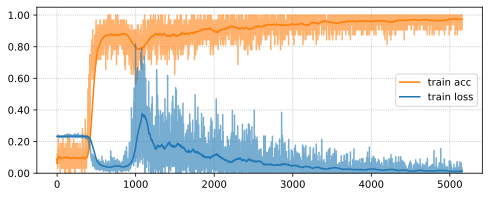

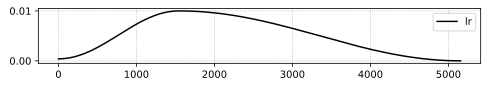

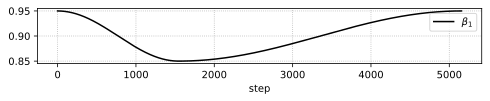

In [18]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(8, 3))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(np.array(trainer.train_log["accu"]), alpha=0.6, color="C1")
plt.plot(np.array(trainer.train_log["accu_avg"]), color="C1", label="train acc")
plt.plot(np.array(trainer.train_log["loss"]) / 10, alpha=0.6, color="C0")
plt.plot(np.array(trainer.train_log["loss_avg"]) / 10, color="C0", label="train loss")
plt.grid(linestyle="dotted")
plt.ylim(0.00, 1.05)
plt.legend()

plt.figure(figsize=(8, 1))
plt.plot(scheduler_stats.lr, color="black", label="lr")
plt.grid(linestyle="dotted")
plt.legend()

plt.figure(figsize=(8, 1))
plt.xlabel("step")
plt.plot(scheduler_stats.momentum, color="black", label=r"$\beta_1$")
plt.grid(linestyle="dotted")
plt.legend();

**Figure.** Note peak in train loss as LR increases to `max_lr` set at initialization, and the decreasing noise as the LR decreases at the end of training.
This works similar to the **LR finder** which is a parameter-free method for finding a good base `lr` (see [notebook](dl/02-optim)).
The bump in learning rate occurs over a wide duration during training, 
so that the optimizer avoids many sharp minima. 
This allows the network to train with less epochs &mdash; increasing the number of 
epochs increases the exploration time (not just convergence time).

### Feature maps

Showing intermediate activations. Recall that feature map in the input of a convolutional layer is used to create each output feature map. Max-pooling and SELU on the other hand acts on each feature map independently. Note that fully-connected layer outputs are reshaped to two dimensions for the sake of presentation.

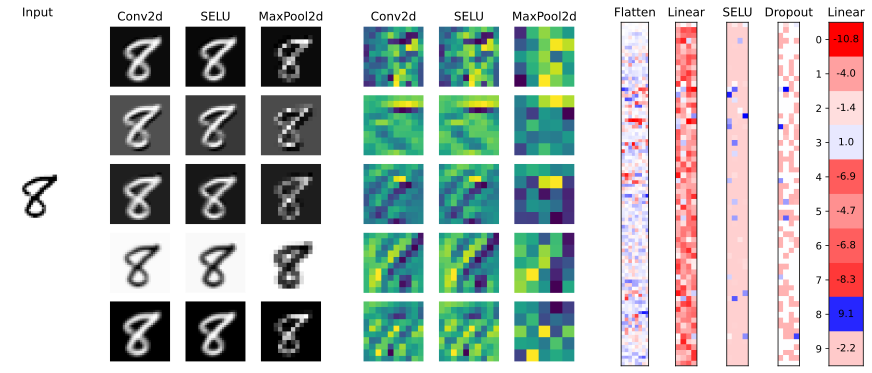

In [19]:
from matplotlib.colors import LinearSegmentedColormap

x, y = next(iter(dl_valid))
b = torch.argmax((y == 8).type(torch.int64))
x = x[b:b+1, :].to(DEVICE) # first element

width_ratios = [1, 0.2, 1, 1, 1, 0.2, 1, 1, 1, 0.2, 0.6, 0.6, 0.6, 0.6, 0.8]
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
spec = fig.add_gridspec(5, len(width_ratios), width_ratios=width_ratios)
cmap = LinearSegmentedColormap.from_list("custom", ["red", "white", "blue"])

# Input image
input_layer = []
for i in range(5):
    input_layer.append(fig.add_subplot(spec[i, 0]))
    input_layer[i].set_axis_off()

input_layer[2].imshow(x[0, 0].cpu().detach().numpy(), cmap="Greys")
input_layer[0].set_title("Input")

# Block 1
for k in range(3):
    x = model[k](x)
    layer = []
    for i in range(5):
        layer.append(fig.add_subplot(spec[i, k + 2]))
        layer[i].set_axis_off()
        layer[i].imshow(x[0, i+10].cpu().detach().numpy(), cmap="Greys")
        layer[i].axis("off")
    layer[0].set_title(type(model[k]).__name__)

# Block 2
for k in range(3):
    x = model[3 + k](x)
    layer = []
    for i in range(5):
        layer.append(fig.add_subplot(spec[i, k + 6]))
        layer[i].set_axis_off()
        layer[i].imshow(x[0, i].cpu().detach().numpy())
        layer[i].axis("off")
    layer[0].set_title(type(model[k]).__name__)

# Classification subnetwork
for l in range(5):
    x = model[6 + l](x)
    if l == 0:
        data = x[0].cpu().detach().view(-1, 8).numpy()
    elif l < 4:
        data = x[0].cpu().detach().view(-1, 4).numpy()
    else:
        data = x[0].cpu().detach().view(-1, 1).numpy()

    a = np.abs(data).max()
    ax = fig.add_subplot(spec[:, 10 + l])
    ax.imshow(data, cmap=cmap, vmin=-a, vmax=a)
    ax.xaxis.set_visible(False)
    ax.set_title(type(model[6 + l]).__name__)
    ax.tick_params(axis="y", colors="white")


# For last layer annotate value
for i in range(10):
    ax.tick_params(axis="y", colors="black")
    ax.set_yticks(range(10))
    ax.text(0, i, f"{data[i, 0]:.1f}", ha="center", va="center", color="black")
    
fig.tight_layout(pad=0.00)

Model predict probability (increase [temperature](https://stats.stackexchange.com/a/527082) to make the distribution look more random):

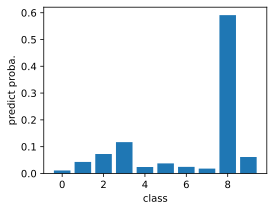

In [20]:
temp = 5.0
plt.figure(figsize=(4, 3))
plt.bar(range(10), F.softmax(x / temp, dim=1).detach().cpu()[0])
plt.xlabel("class")
plt.ylabel("predict proba.");

## Data augmentation

MNIST is too nice to be representative of real-world datasets. Below we continue with a more realistic Kaggle dataset, [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). The task is to detect metastatic cancer in patches of images from digital pathology scans.
Download the dataset such that the folder structure looks as follows:

In [21]:
!tree -L 1 ./data/histopathologic-cancer-detection

./data/histopathologic-cancer-detection
├── test
├── train
└── train_labels.csv

3 directories, 1 file


Taking a look at the first few images:

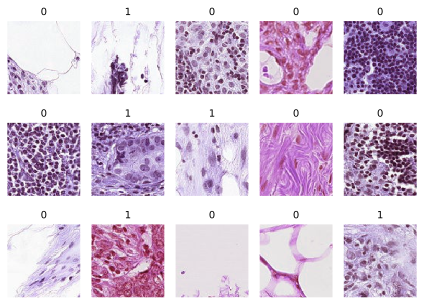

In [22]:
import cv2

IMG_DATASET_DIR = DATASET_DIR / "histopathologic-cancer-detection"
data = pd.read_csv(IMG_DATASET_DIR / "train_labels.csv")
fig, ax = plt.subplots(3, 5, figsize=(6, 4.5))

for k in range(15):
    i, j = divmod(k, 5)
    fname = str(IMG_DATASET_DIR / "train" / f"{data.id[k]}.tif")
    ax[i, j].imshow(cv2.imread(fname))
    ax[i, j].set_title(data.label[k], size=10)
    ax[i, j].axis("off")

fig.tight_layout()

A positive label indicates that the center 32 × 32 region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

### Stochastic transforms

Data augmentation incorporates transformed or perturbed versions of the original images into the dataset. More precisely, each data point
$(\boldsymbol{\mathsf{x}}, y)$ in a mini-batch is replaced by $(T(\boldsymbol{\mathsf{x}}), y)$ during training
where $T$ is a stochastic label preserving transformation. At inference, an input $\boldsymbol{\mathsf{x}}$ is replaced by $\mathbb{E}[T(\boldsymbol{\mathsf{x}})].$

In [23]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop([49, 49]),
])

transform_infer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop([49, 49]),
])

Since only the central pixels affect the labels by design, we use center crop. Furthermore, we know tissue samples in the slides can be flipped horizontally and vertically, as well as rotated (set to $\pm 20^{\circ}$ above) without affecting the actual presence of tumor tissue.

In [24]:
from torch.utils.data import DataLoader, Dataset, Subset

class HistopathologicDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        split = "train" if train else "test"
        self.fnames = [str(IMG_DATASET_DIR / split / f"{fn}.tif") for fn in data.id]
        self.labels = data.label.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, index):
        img = cv2.imread(self.fnames[index])
        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[index]


data = data.sample(frac=1.0)
split = int(0.80 * len(data))
ds_train = HistopathologicDataset(data[:split], train=True, transform=transform_train)
ds_valid = HistopathologicDataset(data[split:], train=True, transform=transform_infer)

Some imbalance (not too severe):

In [25]:
# percentage of positive class
data[:split].label.mean(), data[split:].label.mean()

(0.4050562436086808, 0.4049312578116123)

Simulating images across epochs:

In [26]:
simul_train = DataLoader(Subset(ds_train, torch.arange(3)), batch_size=3, shuffle=True)
simul_valid = DataLoader(Subset(ds_valid, torch.arange(1)), batch_size=1, shuffle=False)

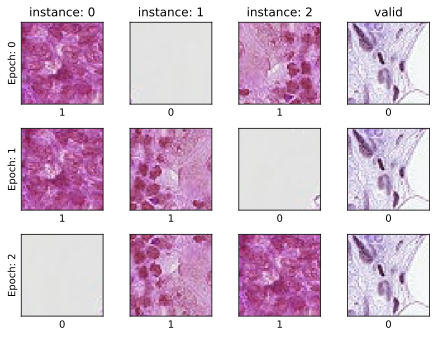

In [27]:
fig, ax = plt.subplots(3, 4)
for e in range(3):
    img_train, tgt_train = next(iter(simul_train))
    for i in range(3):
        if i == 0:
            ax[e, i].set_ylabel(f"Epoch: {e}")
        
        img, tgt = img_train[i], tgt_train[i]
        ax[e, i].imshow(img.permute(1, 2, 0).detach())
        ax[e, i].set_xlabel(tgt.item())
        ax[e, i].set_xticks([])
        ax[e, i].set_yticks([])
        ax[0, i].set_title(f"instance: {i}")

    img_valid, tgt_valid = next(iter(simul_valid))
    ax[e, 3].set_xlabel(tgt_valid[0].item())
    ax[e, 3].imshow(img_valid[0].permute(1, 2, 0).detach())
    ax[e, 3].set_xticks([])
    ax[e, 3].set_yticks([])

ax[0, 3].set_title("valid")
fig.tight_layout()

**Figure.** Training instances are stochastically transformed at each epoch. Meanwhile, test instances  have fixed transformations, i.e. the expectation of the random transformations.
Note that labels are not affected (both at the recognition and implementation level).

## Transfer learning

Transfer learning is a common technique for leveraging large models trained on related tasks (i.e. the so-called **pretrained model**). Here we use ResNet {cite}`resnet` trained on [ImageNet](https://image-net.org/) which consists of millions of images in 1000 categories. This requires us to replace the **classification head** which is task specific, and retain the feature extractors.

To avoid nullifying the pretrained weights, we first train the classification head to convergence while keeping the weights of the pretrained model fixed. Then, we will proceed to **fine-tune** the pretrained weights with a low learning rate, again so that the pretrained weights are gradually changed.

In [28]:
import torchinfo
from torchvision import models

resnet = models.resnet18(pretrained=True)

BATCH_SIZE = 16
torchinfo.summary(resnet, input_size=(BATCH_SIZE, 3, 49, 49))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 25, 25]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 25, 25]          128
├─ReLU: 1-3                              [16, 64, 25, 25]          --
├─MaxPool2d: 1-4                         [16, 64, 13, 13]          --
├─Sequential: 1-5                        [16, 64, 13, 13]          --
│    └─BasicBlock: 2-1                   [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-1                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-3                    [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-4                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-6                    [16, 64, 13, 13]          --
│

In [29]:
in_features = resnet.fc.in_features
num_hidden = 256

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features, num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(num_hidden, 2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

**Remark.** This network is fairly deep, so we use **batch normalization** (BN) {cite}`batchnorm` to aid with activation and gradient stability. BN is discussed in more detail in a future notebook. Dropout is also used to regularize the dense layers.

### Static features

Freezing the feature extraction layers:

In [30]:
for param in model[0].parameters(): # model[0] = pretrained
    param.requires_grad = False

Setting up the data loaders:

In [31]:
dl_train = DataLoader(Subset(ds_train, torch.arange(32000)), batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(Subset(ds_valid, torch.arange(8000)),  batch_size=BATCH_SIZE, shuffle=False)

Training the model using AdamW {cite}`adamw` with learning rate `0.001`:

In [32]:
epochs = 10
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(dl_train), epochs=epochs)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 01/10]    loss: 0.6037  acc: 0.6981    val_loss: 0.5387  val_acc: 0.7458
[Epoch: 02/10]    loss: 0.5832  acc: 0.6981    val_loss: 0.5294  val_acc: 0.7445
[Epoch: 03/10]    loss: 0.5994  acc: 0.6769    val_loss: 0.5319  val_acc: 0.7519
[Epoch: 04/10]    loss: 0.5959  acc: 0.6856    val_loss: 0.5551  val_acc: 0.7368
[Epoch: 05/10]    loss: 0.5661  acc: 0.7106    val_loss: 0.5156  val_acc: 0.7614
[Epoch: 06/10]    loss: 0.5728  acc: 0.7125    val_loss: 0.5184  val_acc: 0.7472
[Epoch: 07/10]    loss: 0.5660  acc: 0.7119    val_loss: 0.5091  val_acc: 0.7605
[Epoch: 08/10]    loss: 0.5458  acc: 0.7275    val_loss: 0.4924  val_acc: 0.7721
[Epoch: 09/10]    loss: 0.5546  acc: 0.7238    val_loss: 0.4818  val_acc: 0.7804
[Epoch: 10/10]    loss: 0.5503  acc: 0.7325    val_loss: 0.4819  val_acc: 0.7831


In [33]:
def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    num_epochs = len(trainer.valid_log["accu"])
    num_steps_per_epoch = len(trainer.train_log["accu"]) // num_epochs
    ax[0].plot(trainer.train_log["loss"], alpha=0.3, color="C0")
    ax[1].plot(trainer.train_log["accu"], alpha=0.3, color="C0")
    ax[0].plot(trainer.train_log["loss_avg"], label="train", color="C0")
    ax[1].plot(trainer.train_log["accu_avg"], label="train", color="C0")
    ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["loss"], label="valid", color="C1")
    ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["accu"], label="valid", color="C1")
    ax[0].set_xlabel("step")
    ax[0].set_ylabel("loss")
    ax[0].grid(linestyle="dashed", alpha=0.3)
    ax[1].set_xlabel("step")
    ax[1].set_ylabel("accuracy")
    ax[1].grid(linestyle="dashed", alpha=0.3)
    ax[1].legend()
    ax[0].set_ylim(0, max(trainer.train_log["loss"]))
    ax[1].set_ylim(0, 1)
    ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    
    fig.tight_layout();

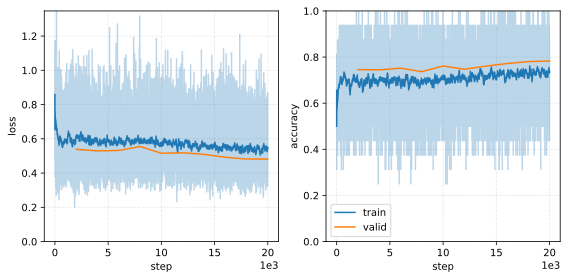

In [34]:
plot_training_history(trainer)

**Remark.** The validation step accumulates results over after an epoch for a fixed set of weights. This simulates inference performance if we load the trained model at that **checkpoint**. On the other hand, train metrics are expensive since the training dataset is large. Instead, these are accumulated at each step as an average with the previous steps.

### Fine-tuning

Unfreezing the pretrained model layers. Note that we set small learning rates:

In [35]:
for param in model[0].parameters():
    param.requires_grad = True

# 100x smaller lr (both optim and scheduler)
epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)
scheduler = OneCycleLR(optim, max_lr=0.0001, steps_per_epoch=len(dl_train), epochs=epochs)
trainer_ft = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer_ft.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 01/20]    loss: 0.4745  acc: 0.7869    val_loss: 0.4261  val_acc: 0.8183
[Epoch: 02/20]    loss: 0.4400  acc: 0.7981    val_loss: 0.3835  val_acc: 0.8383
[Epoch: 03/20]    loss: 0.3977  acc: 0.8287    val_loss: 0.3621  val_acc: 0.8508
[Epoch: 04/20]    loss: 0.3465  acc: 0.8506    val_loss: 0.3321  val_acc: 0.8640
[Epoch: 05/20]    loss: 0.4192  acc: 0.8244    val_loss: 0.3339  val_acc: 0.8626
[Epoch: 06/20]    loss: 0.3815  acc: 0.8319    val_loss: 0.3338  val_acc: 0.8644
[Epoch: 07/20]    loss: 0.3399  acc: 0.8600    val_loss: 0.3129  val_acc: 0.8758
[Epoch: 08/20]    loss: 0.3154  acc: 0.8731    val_loss: 0.3132  val_acc: 0.8730
[Epoch: 09/20]    loss: 0.3383  acc: 0.8631    val_loss: 0.3250  val_acc: 0.8720
[Epoch: 10/20]    loss: 0.3081  acc: 0.8700    val_loss: 0.2879  val_acc: 0.8879
[Epoch: 11/20]    loss: 0.2872  acc: 0.8831    val_loss: 0.2925  val_acc: 0.8858
[Epoch: 12/20]    loss: 0.2884  acc: 0.8912    val_loss: 0.2890  val_acc: 0.8886
[Epoch: 13/20]    loss: 0.30

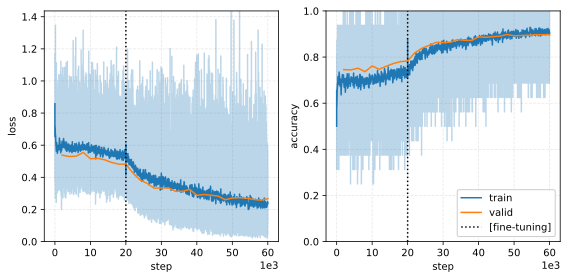

In [36]:
loss = trainer.train_log["loss"] + trainer_ft.train_log["loss"]
accu = trainer.train_log["accu"] + trainer_ft.train_log["accu"]
loss_avg = trainer.train_log["loss_avg"] + trainer_ft.train_log["loss_avg"]
accu_avg = trainer.train_log["accu_avg"] + trainer_ft.train_log["accu_avg"]
val_loss = trainer.valid_log["loss"] + trainer_ft.valid_log["loss"]
val_accu = trainer.valid_log["accu"] + trainer_ft.valid_log["accu"]
num_epochs = len(val_loss)
num_steps_per_epoch = len(loss) // num_epochs

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss, alpha=0.3, color="C0")
ax[1].plot(accu, alpha=0.3, color="C0")
ax[0].plot(loss_avg, label="train", color="C0")
ax[1].plot(accu_avg, label="train", color="C0")
ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_loss, label="valid", color="C1")
ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_accu, label="valid", color="C1")
ax[0].axvline(len(trainer.train_log["loss"]), color="black", linestyle="dotted", label="[fine-tuning]")
ax[1].axvline(len(trainer.train_log["loss"]), color="black", linestyle="dotted", label="[fine-tuning]")
ax[0].set_xlabel("step")
ax[0].set_ylabel("loss")
ax[0].grid(linestyle="dashed", alpha=0.3)
ax[0].set_ylim(0, max(loss))
ax[1].set_xlabel("step")
ax[1].set_ylabel("accuracy")
ax[1].grid(linestyle="dashed", alpha=0.3)
ax[1].set_ylim(0, 1)
ax[1].legend(framealpha=1.0)
ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
fig.tight_layout();

**Figure.** The weights of the classification head are trained on the outputs of the pretrained ResNet model with fixed weights. After the classification head forms proper weights, the pretrained weights are unfreezed, and thereby trained with small LR. The performance improves at a faster rate but also fluctuates more at this stage.

<br>

**Remarks.** If we turn off data augmentation the validation curves diverge and the model overfits very early in the training (i.e. model memorizes the training data). Data augmentation prevents this by adding noise in the input. The dense layers also does not train well without BN. Recall that the data is imbalanced, so it is imperative to look at further evaluation tools such as the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and [PR curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

### Inference

The trainer `batch_predict` method takes a data loader for inference. Note that simply calling the model on an input `x` may cause memory error for large models. Hence, using a data loader inference is good practice:

In [37]:
class InputDataLoader(DataLoader):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def __iter__(self):
        for batch in self.data_loader:
            yield batch[0]

pred = trainer.batch_predict(InputDataLoader(dl_valid))
print(pred.shape)
print(pred)

torch.Size([8000, 2])
tensor([[-0.2174,  0.2039],
        [ 1.1511, -1.1528],
        [ 0.7306, -0.7436],
        ...,
        [ 0.8275, -0.8382],
        [-2.5869,  2.5430],
        [-2.2528,  2.2162]], device='mps:0')


This should be equal to the final validation accuracy:

In [38]:
y = torch.cat([batch[1] for batch in dl_valid], dim=0)
print((pred.argmax(dim=1) == y.to(DEVICE)).float().mean().item())
print(trainer_ft.evaluate(dl_valid)["accu"])
print(trainer_ft.valid_log["accu"][-1]) # or look at final valid log

0.8966250419616699
0.896625
0.896625


**Remark.** Recall that data points in our data loader come transformed. For processing raw images, we may have to call the eval mode transformation during model deployment as follows:

In [39]:
file_path = "data/histopathologic-cancer-detection/test/0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif"
test_data = cv2.imread(file_path)
print(trainer.predict(transform_infer(test_data).unsqueeze(0)))

tensor([[ 1.1124, -1.1111]], device='mps:0')


## Appendix: Guided Backprop

To explain the outputs of convolutional networks, we can look at the effect of each
pixel in the input on each output node corresponding to a class.
That is, we consider gradients $\partial y / {\partial \boldsymbol{\mathsf{X}}^{\ell}}_{ij}$
for a target class $y$ where $\ell = 0$ for the input image.
Note that gradients can be negative in intermediate layers, so to get a stronger signal
we mask these gradients when computing backpropagation with respect to ${\boldsymbol{\mathsf{X}}^0}_{ij}$.
In effect, we backpropagate only through those neurons which cause a first-order increase
in the target class $y$. 

Moreover, positive activation indicate pattern detection for each node, hence 
we mask out nodes with negative activations further strengthening the signal.
Since this is applied to all layers, we get patterns which are compositional
and would eventually result in a positive activation for the target node.
The gradients on input pixels are calculated with these two masks in place.
This method is called **Guided Backpropagation** (GB) {cite}`allconv` used to obtain fine-grained
details in the input image that contribute to the target class.

```{figure} ../../img/nn/03-guided_backprop.png
---
name: 03-guided_backprop
width: 100%
---
Schematic of visualizing the activations of high layer neurons. Source: Fig. 1 of {cite}`allconv`
```

In [40]:
def standardize_and_clip(x, min_val=0.0, max_val=1.0, saturation=0.1, brightness=0.5):
    x = x.detach().cpu()
    u = x.mean()
    v = max(x.std(), 1e-7)
    standardized = x.sub(u).div(v).mul(saturation)
    clipped = standardized.add(brightness).clamp(min_val, max_val)
    return clipped

def relu_hook_function(module, grad_in, grad_out):
    # Mask out negative gradients, and negative outputs
    # Note: ∂relu(x)/∂x = [x > 0] = [relu(x) > 0], 
    # so that ∂(relu input) = [relu(x) > 0] * ∂(relu output).
    # This explains why we take the gradient wrt relu input.
    return (torch.clamp(grad_in[0], min=0.),)

def resize(x):
    return transforms.Resize(size=(224, 224))(x)

def register_hooks(model):
    hooks = []
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            h = module.register_backward_hook(relu_hook_function)
            hooks.append(h)
    return hooks

def guided_backprop(model, x, target=None):
    hooks = register_hooks(model)

    # backward through target node
    with eval_context(model):
        p = model(x)
        if target is None:
            target = p.argmax().item()

        y = p[0, target]
        y.backward()

    g = standardize_and_clip(x.grad)
    g = g.to("cpu")
    x = x.to("cpu")
    
    # cleanup (gradients and hooks)
    for _, module in model.named_modules():
        module.zero_grad()

    for h in hooks:
        h.remove()

    return {
        "x": resize(x[0]),
        "g": resize(g[0]).max(dim=0)[0],    # <- max guided backprop! [1, H, W] map.
        "p": F.softmax(p, dim=1)[0, target]
    }   


# viz pathological tissue samples
outs = {}
target = 1
num_samples = 3
for b in range(num_samples):
    
    # prepare input image
    filepath = "data/histopathologic-cancer-detection/train"
    filename = data[data.label == target].iloc[b, 0]
    image = f"{filepath}/{filename}.tif"
    x = transform_infer(cv2.imread(image)).unsqueeze(0).to(DEVICE)
    x.requires_grad = True
    
    # magic happening...
    outs[b] = guided_backprop(model, x, target)

```{margin}
💡 See [this video](https://www.youtube.com/watch?v=syLFCVYua6Q) on PyTorch hooks
for an introduction.
```
**Remark.** The backward 
hooks for masking negative gradients are only attached to ReLU layers 
since the network only has ReLU activations. See comments in the code. 
For other activations, you may need to implement
forward hooks to mask out negative activations. 

Note that backward hooks are executed
before the tensor saves its gradients. 
Moreover, its return value modifies the input gradients of the given module.
Finally, we take the maximum for each input image channel 
to get a grayscale map for the gradients.

In [41]:
def normalize(x):
    """Map pixels to [0, 1]."""
    return (x - x.min()) / (x.max() - x.min())

# these can be sliders in a viz. app
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75

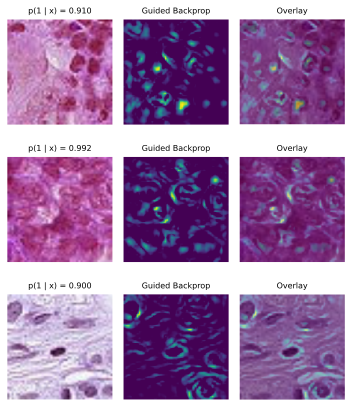

In [42]:
fig, ax = plt.subplots(num_samples, 3, figsize=(5, 6))
for b in range(num_samples):
    ax[b, 0].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 1].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
    ax[b, 2].imshow(normalize(outs[b]["x"]).detach().permute(1, 2, 0).cpu().numpy())
    ax[b, 2].imshow(standardize_and_clip(outs[b]["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
    ax[b, 0].axis("off")
    ax[b, 1].axis("off")
    ax[b, 2].axis("off")
    ax[b, 0].set_title(f"p({target} | x) = {outs[b]['p']:.3f}", size=8)
    ax[b, 1].set_title("Guided Backprop", size=8)
    ax[b, 2].set_title("Overlay", size=8)

fig.tight_layout()

Not a domain expert on histopathology,
so let us compare how this looks like with pretrained AlexNet on a dog image.

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = cv2.imread("./data/shorty.png")
x = transform(image).unsqueeze(0).to(DEVICE)
x.requires_grad = True

alexnet = models.alexnet(pretrained=True).to(DEVICE)
out = guided_backprop(alexnet, x, target=None)

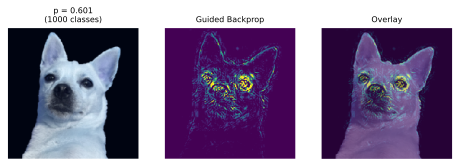

In [44]:
min_val = 0.5
max_val = 10.0
overlay_alpha = 0.75
fig, ax = plt.subplots(1, 3, figsize=(8, 10))
ax[0].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[1].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis")
ax[2].imshow(normalize(out["x"]).detach().permute(1, 2, 0).cpu().numpy())
ax[2].imshow(standardize_and_clip(out["g"], min_val=min_val, max_val=max_val).cpu().numpy(), cmap="viridis", alpha=overlay_alpha)
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[0].set_title(f"p = {out['p']:.3f}\n(1000 classes)", size=8)
ax[1].set_title("Guided Backprop", size=8)
ax[2].set_title("Overlay", size=8);

**Remark.** It's interesting that the model can pick out whiskers from the input image.

## Appendix: Text classification

In this section, we train a convolutional network on text embeddings. In particular, our dataset from https://github.com/jvalhondo/spanish-names-surnames consist of Spanish given names. Our task is to classify these into its gender label provided in the dataset. Note that the following is purely an academic exercise. The resulting model could perpetuate bias if used in real-world applications.

In [45]:
%%bash
wget -O ./data/spanish-male-names.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/male_names.csv
wget -O ./data/spanish-female-names.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/female_names.csv

--2024-07-29 04:43:47--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/male_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491187 (480K) [text/plain]
Saving to: ‘./data/spanish-male-names.csv’

     0K .......... .......... .......... .......... .......... 10% 3.48M 0s
    50K .......... .......... .......... .......... .......... 20% 54.0M 0s
   100K .......... .......... .......... .......... .......... 31% 5.75M 0s
   150K .......... .......... .......... .......... .......... 41% 12.8M 0s
   200K .......... .......... .......... .......... .......... 52% 31.1M 0s
   250K .......... .......... .......... .......... .......... 62% 59.5M 0s
   300K .......... .......... .......... .......... .......... 72% 35.3M 0s
   

In [46]:
dfm = pd.read_csv(DATASET_DIR / "spanish-male-names.csv")
dff = pd.read_csv(DATASET_DIR / "spanish-female-names.csv")
dfm = dfm[["name"]].dropna(axis=0, how="any")
dff = dff[["name"]].dropna(axis=0, how="any")
dfm["gender"] = "M"
dff["gender"] = "F"

df = pd.concat([dfm, dff], axis=0)
df["name"] = df.name.map(lambda s: s.replace(" ", "_").lower())
df = df.drop_duplicates().reset_index(drop=True)
df

name gender
0           antonio      M
1              jose      M
2            manuel      M
3         francisco      M
4              juan      M
...             ...    ...
49334        zhihui      F
49335  zoila_esther      F
49336       zsanett      F
49337        zuleja      F
49338       zulfiya      F

[49339 rows x 2 columns]

In [47]:
df.gender.value_counts()

gender
F    24755
M    24584
Name: count, dtype: int64

The histogram of name lengths is multimodal due to having multiple subnames
separated by space.

Max name length: 27


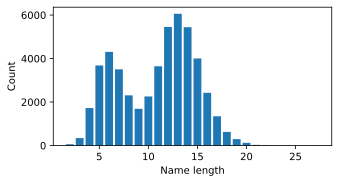

In [48]:
from collections import Counter

name_length = Counter([len(n) for n in df.name])
lengths = sorted(name_length.keys())
plt.figure(figsize=(5, 2.5))
plt.bar(lengths, [name_length[k] for k in lengths])
plt.xlabel("Name length")
plt.ylabel("Count")
print("Max name length:", max(lengths))

In [49]:
len(df[df.name.apply(len) < 23]) / len(df)

0.9997365167514543

### Data loaders

We pad names with one `.` on the left to indicate the start of a name, and enough `.` on the right so that input names have the same length. Long names are truncated to a max length. This is typical for language models due to architectural constraints. In any case, a sufficiently large fixed number of initial characters of a name should be enough to determine the label.

In [50]:
MAX_LEN = 23
CHARS = ["."] + sorted(list(set([c for n in df.name for c in n])))
VOCAB_SIZE = len(CHARS)

print("token count:", VOCAB_SIZE)
print("".join(CHARS))

token count: 31
.'_abcdefghijklmnopqrstuvwxyzçñ


From above, almost all of the names are within 23 characters long. The above padding rule means that inputs to the network have length `MAX_LEN + 1`. 

In [51]:
from torch.utils.data import Dataset, DataLoader, random_split

class NamesDataset(Dataset):
    def __init__(self, names: list[str], label: list[int]):
        self.char_to_int = {c: i for i, c in enumerate(CHARS)}
        self.label_map = {"F": 1, "M": 0}
        self.names = names
        self.label = label

    def encode(self, name: str):
        return [self.char_to_int[char] for char in self.preprocess(name)]

    def decode(self, x: torch.Tensor):
        int_to_char = {i: c for c, i in self.char_to_int.items()}
        return "".join(int_to_char[i.item()] for i in x)
        
    def __len__(self):
        return len(self.names)

    def __getitem__(self, i):
        y = torch.tensor(self.label_map[self.label[i]])
        x = torch.tensor(self.encode(self.names[i]))
        return x, y

    @staticmethod
    def preprocess(name: str) -> str:
        """Prepend with dot and pad. Final length: MAX_LEN + 1."""
        out = [c for c in name if c in CHARS]
        return "." + "".join(out)[:min(len(out), MAX_LEN)] + "." * (MAX_LEN - len(out))


g = torch.Generator().manual_seed(RANDOM_SEED)
names = df.name.tolist()
label = df.gender.tolist()

ds = NamesDataset(names, label)
ds_train, ds_valid = random_split(ds, [0.8, 0.2], generator=g)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=32, shuffle=False)

Sample instance:

In [52]:
x, y = next(iter(dl_train))
x[:5, :15], y[:5]

(tensor([[ 0,  3, 11,  6,  3,  2, 11, 16,  7, 21,  0,  0,  0,  0,  0],
         [ 0,  5, 14,  3, 20,  3,  2, 14, 23, 11, 21,  3,  0,  0,  0],
         [ 0,  7, 14,  7, 16,  3,  2,  3, 16,  5, 23, 22,  3,  0,  0],
         [ 0, 12, 10, 17, 16,  2,  3, 14,  7, 26, 11, 21,  0,  0,  0],
         [ 0,  9,  3, 23, 15,  7, 22,  0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([1, 1, 1, 0, 0]))

Decoding:

In [53]:
for i in range(5):
    name = ds.decode(x[i])
    print(name, {1: "F", 0: "M"}[y[i].item()])

.aida_ines.............. F
.clara_luisa............ F
.elena_ancuta........... F
.jhon_alexis............ M
.gaumet................. M


### Model

The convolution kernel runs across a context of characters with stride 1. Subnames are short, so a context size of 3 or 4 should be good. Note that we use **embeddings** as input to the convolutional layers of size `d_emb`. Hence, the kernel is applied to sequential blocks of embeddings that have size `n × d_emb` where `n` is the context size, and a stride `d_emb` which is equivalent to skipping one character ({numref}`03-text-cnn`).

```{figure} ../../img/nn/03-text-cnn.png
---
width: 740px
name: 03-text-cnn
---

Model architecture to classify text using convolutions. The kernel slides over embeddings instead of pixels. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

```{figure} ../../img/nn/03-maxpool-over-time.png
---
width: 500px
name: 03-maxpool-over-time
---

Zooming in on a portion of the model architecture in {numref}`03-text-cnn`. Max pooling over time reduces the feature map to a vector whose entries correspond to the largest value in each output channel over the entire sequence. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

The model determines the gender label of a name by looking at the presence of certain *n*-grams in a name (i.e. one detector for each channel), regardless of its position in the name. This is done using **max pool over time** ({numref}`03-maxpool-over-time`) which converts the `[conv_width, T]` tensor to `[conv_width, 1]` containing the max activations. Here `conv_width` is the number of *n*-gram detectors where *n* is the context size. Finally, the resulting vector is passed to an MLP. 

Implementing the model:

In [54]:
import torchinfo

class TextCNN(nn.Module):
    def __init__(self, 
                 d_emb=10,
                 context=3,
                 fc_width=256,
                 conv_width=64,
                 vocab_size=VOCAB_SIZE):

        super().__init__()
        T = (MAX_LEN + 1) - context + 1  # no. conv steps
        
        self.C = nn.Embedding(vocab_size, d_emb)
        self.conv1 = nn.Conv1d(1, conv_width, context*d_emb, d_emb)
        self.relu1 = nn.ReLU()
        self.pool_over_time = nn.MaxPool1d(T)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_width, fc_width),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_width, 2)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.C(x)
        x = x.reshape(B, 1, -1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool_over_time(x)
        return self.fc(x.reshape(B, -1))


torchinfo.summary(TextCNN(), input_size=(1, MAX_LEN + 1), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [1, 2]                    --
├─Embedding: 1-1                         [1, 24, 10]               310
├─Conv1d: 1-2                            [1, 64, 22]               1,984
├─ReLU: 1-3                              [1, 64, 22]               --
├─MaxPool1d: 1-4                         [1, 64, 1]                --
├─Sequential: 1-5                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 256]                  16,640
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─Linear: 2-4                       [1, 2]                    514
Total params: 19,448
Trainable params: 19,448
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.08
Estimated Total Size (MB): 0.09

### Training

In [55]:
model = TextCNN(conv_width=128, context=4, fc_width=256)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=5, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 0.2173  acc: 0.9052    val_loss: 0.2180  val_acc: 0.9035
[Epoch: 2/5]    loss: 0.1763  acc: 0.9221    val_loss: 0.1814  val_acc: 0.9230
[Epoch: 3/5]    loss: 0.1716  acc: 0.9283    val_loss: 0.1833  val_acc: 0.9166
[Epoch: 4/5]    loss: 0.1699  acc: 0.9226    val_loss: 0.1679  val_acc: 0.9247
[Epoch: 5/5]    loss: 0.1585  acc: 0.9262    val_loss: 0.1661  val_acc: 0.9263


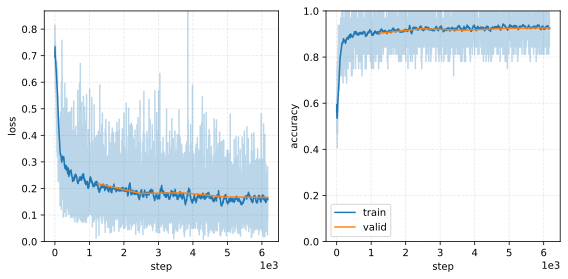

In [56]:
plot_training_history(trainer)

### Inference

In [57]:
data = [ 
    "maria",
    "clara",
    "maria_clara",
    "tuco",
    "salamanca",
    "tuco_salamanca",
]

# Model prediction
x = torch.tensor([ds.encode(n) for n in data])
probs = F.softmax(trainer.predict(x), dim=1)[:, 1].cpu()  # p(F|name)

In [58]:
print("name                         p(F|name)")
print("--------------------------------------")
for i, name in enumerate(data):
    print(f"{name + ' ' * (MAX_LEN - len(name))} \t{probs[i]:.3f}")

name                         p(F|name)
--------------------------------------
maria                   	0.988
clara                   	0.980
maria_clara             	1.000
tuco                    	0.009
salamanca               	0.795
tuco_salamanca          	0.046


**Remark.** The model seems to compose inputs well since the model is able to perform convolution over spaces (`_`).

## Appendix: Maximal class input

In [59]:
del resnet

In this section, we optimize an image $\boldsymbol{\mathsf{x}}$ that maximizes a given class $c.$ The loss function we will use is $-f_c(\boldsymbol{\mathsf{x}}) + 0.1\| \boldsymbol{\mathsf{x}} \|^2$, i.e. we maximize the unnormalized class score instead of the class probability (since the latter can be maximized by decreasing the scores for the other classes). Note that the parameters of the model $f$ is fixed during optimization.

In [60]:
class Input(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.rand(1, 3, 256, 256))

    def forward(self, _):
        return self.x


def maximal_class_input(c: int, num_steps=200, lr=5.0, wd=0.1) -> torch.tensor:
    # https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/    
    
    vgg = models.vgg16(pretrained=True)
    model = nn.Sequential(Input(), vgg)
    for param in model[1].parameters():
        param.requires_grad = False

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    for _ in tqdm(range(num_steps)):
        loss = -model(None)[0, c]
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    return model[0](None)

Here we initialize $\boldsymbol{\mathsf{x}}$ pixels from $U[0, 1]$ and implemented as module parameters. This is prepended to a VGG16 model whose parameters are frozen. Weight decay is used to get more pixel variation across the input field (i.e. more clusters of visual features).

  0%|          | 0/200 [00:00<?, ?it/s]

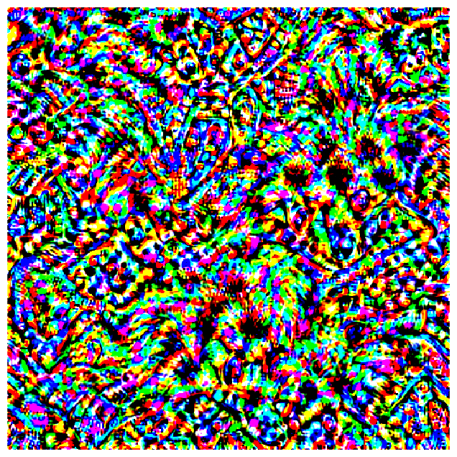

In [61]:
from torchvision.transforms.functional import adjust_sharpness

x = maximal_class_input(259, num_steps=200, lr=5.0)    # pomeranian
x = nn.Upsample(scale_factor=2, mode="bilinear")(x)
x = adjust_sharpness(x, sharpness_factor=0.0)
x = normalize(x)
plt.figure(figsize=(8, 8))
plt.imshow(x[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off");

**Figure.** You may not like it, but this is what the ideal pomeranian looks like.

---
■